# MESA session 3: solution notebook

In [16]:
import os
import numpy as np
import mesa_reader as mr
import matplotlib.pyplot as plt 

import astropy.units as u
import astropy.constants as const


***
# Problem 1:
## Luminosity of Massive Stars at late stages

In [17]:
# Load your computed models (history_data, file)
base = './data/to_C_exhaust/'
masses = [20,30,40]
history_list = [mr.MesaData(os.path.join(base, f'M{m}_DW0_8', 'LOGS', f'M{m}_DW0_8', 'history.data')) for m in masses]

# If you want to check what data is available in the history files, you can use:
# history15.header_names
# history15.bulk_names

In [87]:
# Define a HR diagram plotting function that we can re-use
def HR_diagram(histoy_list, xlim=(None, None), ylim=(None, None), neutrino_luminosity=False,
               Lfrac = True, VMIN=-3, VMAX=0, cmap_name = 'rainbow', colour_by='center_h1', colour_label='kleur',
               save_loc='./plots/'):
    """
    Plot a HR diagram from a list of mesa history data files.
    colour by the fraction of the luminosity from the specified source.
    Lfrac: is the color a fraction of the total luminosity? 
    """
    fig, ax = plt.subplots(figsize=(10, 8))

    # Function to calc R from stefan-boltzmann law
    def Radius(Teff, L):
        Teff = Teff * u.K
        L = (L * u.Lsun).to(u.W)
        R = (L / (4 * np.pi * const.sigma_sb * Teff**4))**0.5
        return R.to(u.Rsun).value

    # --- Radius contour grid ---
    Teffs = np.linspace(3.5, 8, 100)
    Ls = np.linspace(3.5, 7.0, 100)
    Teffs_grid, Ls_grid = np.meshgrid(Teffs, Ls)
    Radius_grid = Radius(10**Teffs_grid, 10**Ls_grid)
    #
    CS = ax.contour(Teffs_grid, Ls_grid, Radius_grid, levels=[1, 10, 100, 1e3, 1e4], colors='#969696', linestyles='dashed')
    ax.clabel(CS, inline=1, inline_spacing=-5, fontsize=15)


    # --- Plot each star ---     
    for i, hist in enumerate(histoy_list):
        # find where to start the center h drops below 0.69
        start = np.flatnonzero(np.asarray(hist.center_h1) < 0.69)[0] if (np.asarray(hist.center_h1) < 0.69).any() else 0

        # get relevant data from the start of MS to 
        log_Teff = hist.log_Teff[start:] 
        log_L    = hist.log_L[start:] 
        log_Lneu = hist.log_Lneu[start:] 
        log_LH   = hist.log_LH[start:]
        log_LHe  = hist.log_LHe[start:]
        log_LZ   = hist.log_LZ[start:]

        C        = np.asarray(getattr(hist, colour_by)[start:])
        if Lfrac:
            C = C-log_L
        else:
        # I'm coloring by center_c12, which we would like to show in log
            C = np.log10(C) 
        
        # We are either plotting a traditional HR diagram, or neutrino luminosity
        if neutrino_luminosity:
            Y_vals = log_Lneu
        else:
            Y_vals = log_L

        ax.plot(log_Teff, Y_vals, c='k', lw = 1, zorder = 0)
        # colour_by='log_LH' -> 10**log_LH / 10**log_L = L_H / L_tot
        scat = ax.scatter(log_Teff, Y_vals, c=C, cmap = cmap_name, 
        vmin=VMIN, vmax=VMAX, s=20, zorder = 1)

        # Annotate the mass of the star at the start of the MS
        ax.scatter(log_Teff[0], Y_vals[0], marker='*', s=50)
        ax.text(log_Teff[0],  Y_vals[0] , f"${np.round(hist.star_mass[0], 0)}$"+"M$_{\odot}$", ha='right', fontsize = 15) #log_Teff

    cb = plt.colorbar(scat, ax=ax)
    cb.set_label(colour_label if colour_label else (f"{colour_by} / L" if Lfrac else colour_by), fontsize=20)

    # -- Plot values -- 
    ax.set_xlabel('log$_{10}$(T$_{eff}$/K)', fontsize=25)
    ax.set_ylabel('log$_{10}$(L/L$_{\\odot}$)', fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=20)
    if xlim != (None, None): ax.set_xlim(xlim)
    if ylim != (None, None): ax.set_ylim(ylim)
    ax.invert_xaxis()
    fig.tight_layout()


    plt.savefig(save_loc + "HR_{colour_by}.png", bbox_inches='tight')
    plt.show()


# 1 a)
## H luminosity as a fraction of the total L

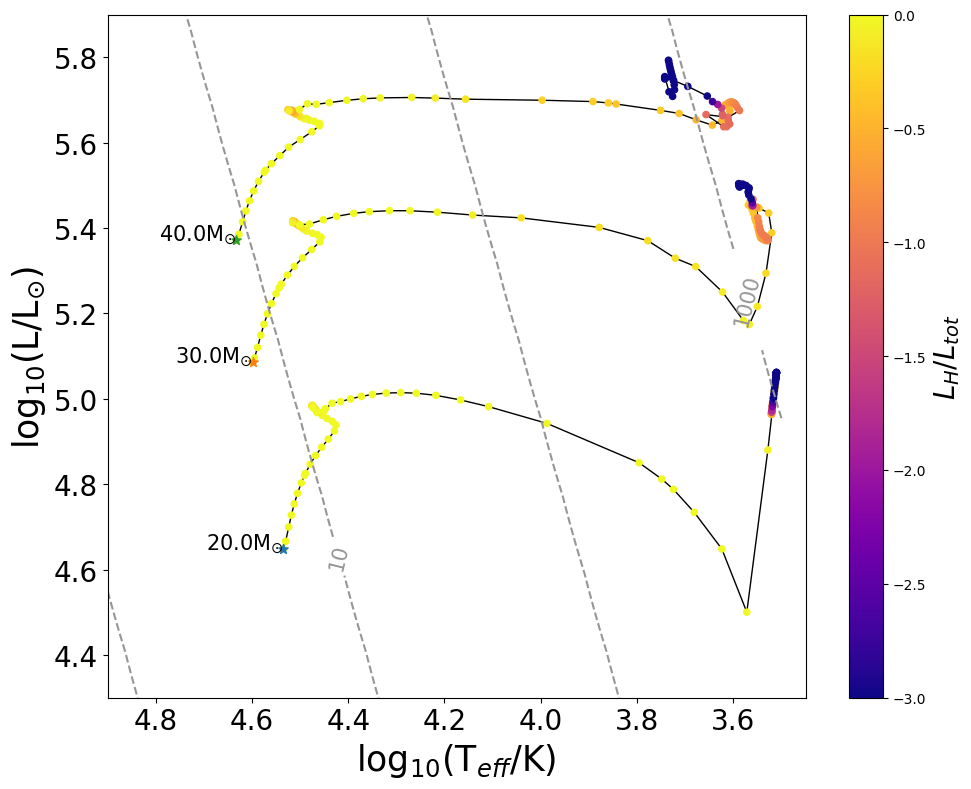

In [88]:
HR_diagram(history_list,
           xlim=(3.45, 4.9), ylim=(4.3, 5.9),
           VMIN=-3, VMAX=0, cmap_name = 'plasma', 
           colour_by='log_LH', colour_label='$L_{H}$/$L_{tot}$')
# center_he4 # center_c12

## He luminosity as a fraction of the total L

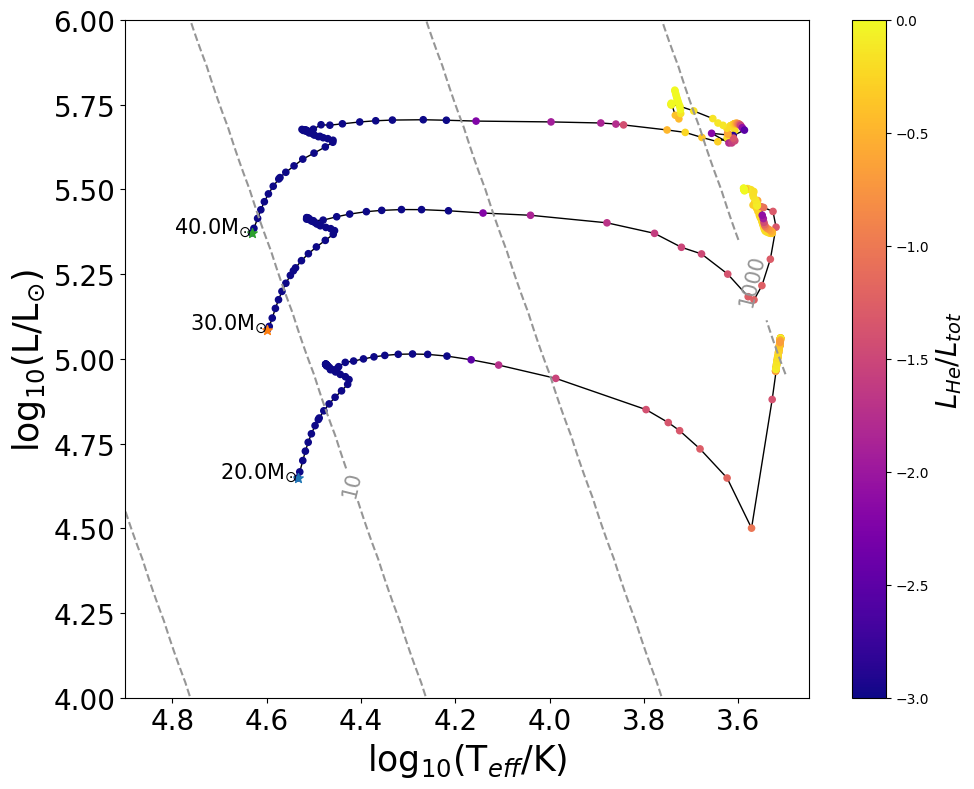

In [89]:
HR_diagram(history_list,
           xlim=(3.45, 4.9), ylim=(4.0, 6.),
           VMIN=-3, VMAX=0, cmap_name = 'plasma', 
           colour_by='log_LHe', colour_label='$L_{He}$/$L_{tot}$')
# center_he4 # center_c12

## Z luminosity as a fraction of the total L

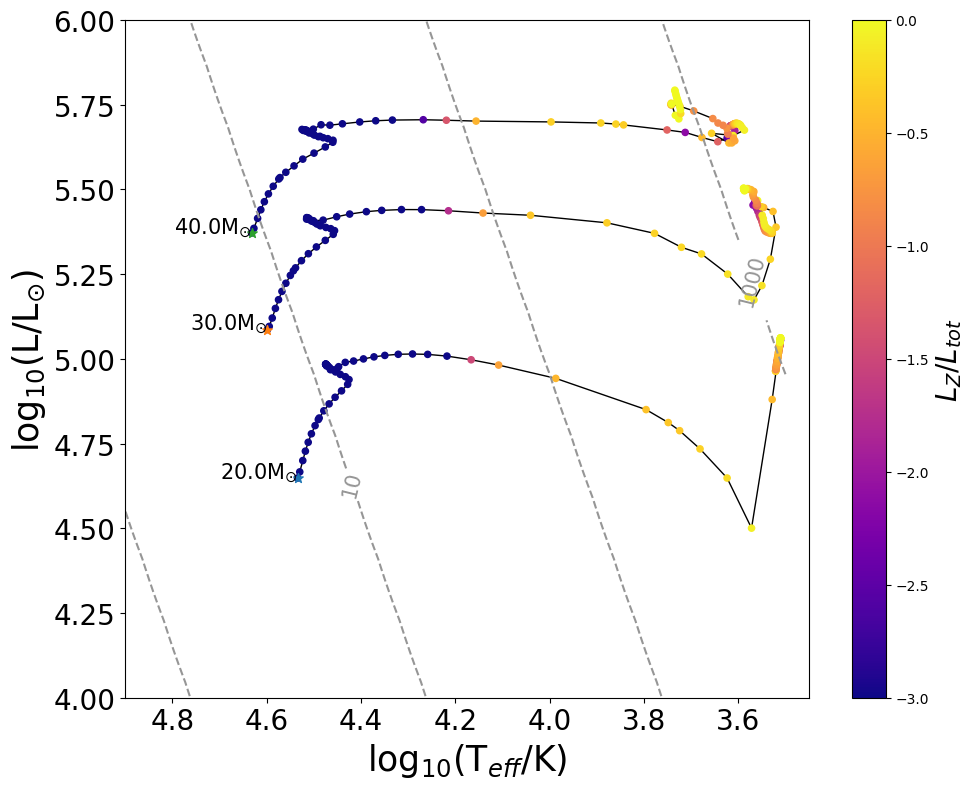

In [90]:
HR_diagram(history_list,
           xlim=(3.45, 4.9), ylim=(4.0, 6.),
           VMIN=-3, VMAX=0, cmap_name = 'plasma', 
           colour_by='log_LZ', colour_label='$L_{Z}$/$L_{tot}$')
# center_he4 # center_c12

# 1 b)
## HR diagram in neutrino luminosity

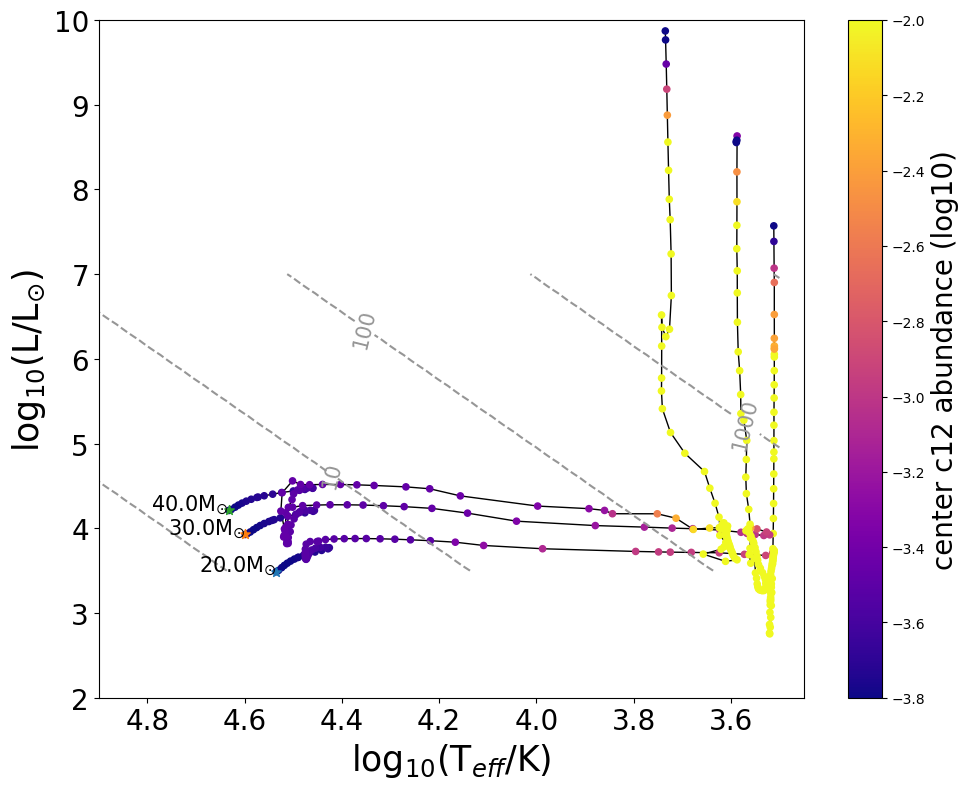

In [94]:
HR_diagram(history_list,neutrino_luminosity = True, 
           xlim=(3.45, 4.9), ylim=(2.0, 10), Lfrac = False, 
           VMIN=-3.8, VMAX=-2, cmap_name = 'plasma',
           colour_by='center_c12', colour_label='center c12 abundance (log10)')


## c) 
We see that hydrogen fusion luminosity dominates during most of the stars path in the HR diagram, due to the MS and H-shell burning phases. 
Helium and metal burning (C burning reactions) only dominate at the very cool side of the HR diagram. L_z starts to contribute before the star has started C ignition in the center: this is due to Carbon + alpha capture in the later stages of He burning.

Most importantly, the neutrino luminosity HR diagram reveals how the late evolution of massive stars is ruled by neutrino emission: the neutrino luminosity of the star at carbon burning (and beyond) is many orders of magnitude larger than the highest photon luminosity the star ever achieves!

***
# 2 Evolution of massive stars with mass loss

In [231]:
# # Read in the new data for our higher mass star with mass loss
# M50_DSF1_hist_data = mr.MesaData('data/session3_workingdir/M50_overshoot0_DSF1p0/history.data')
# M50_DSF05_hist_data = mr.MesaData('data/session3_workingdir/M50_overshoot0_DSF0p5/history.data')
# M50_DSF01_hist_data = mr.MesaData('data/session3_workingdir/M50_overshoot0_DSF0p1/history.data')

#  '/mnt/home/lvanson/ceph/MESAoutput/Teaching/ASBE2025/HW3_experiments/inlist_massive_default_hestop'
var = 'HW3_output_final'
#'delta_HR_limit_0.003_high_varcrtl'
#'delta_HR_limit_0.003_high_varcrtl'
# 'inlist_massive_default_small_varcrtl'#'inlist_massive_default_refine_mesh' #
#'inlist_massive_default_hestop' #'HW3_output'#'delta_HR_limit_0.003'
base = f'/Users/liekevanson/Documents/Teaching/ASBE25/data/{var}'

masses = np.arange(15, 45,5)
print(masses)
# fid_DWs = [mr.MesaData( os.path.join(base, f'M{m}_DW0_8', 'LOGS', f'M{m}_DW0_8', 'history.data') ) for m in masses]
fid_DWs = [mr.MesaData( os.path.join(base, f'M{m}_DW1_0', 'LOGS', f'M{m}_DW1_0', 'history.data') ) for m in masses]


[15 20 25 30 35 40]


In [232]:
summary_dict = {}

# Helper to extract initial mass from folder names like 'M15_*', 'M20_DW1_0', etc.
def mass_from_folder(name):
    m = re.match(r'^M(\d+(?:\.\d+)?)', name)
    return float(m.group(1)) if m else float('inf')

# Collect folders that have a MESArun.out and sort them by mass
folders = [f for f in os.listdir(base) if os.path.isfile(f"{base}/{f}/MESArun.out")]
folders_sorted = sorted(folders, key=mass_from_folder)

# Build the dict in sorted order so JSON prints in mass order
for folder in folders_sorted:
    fpath = f'{base}/{folder}/MESArun.out'
    text = open(fpath).read()

    def get(pat):
        m = re.search(pat, text)
        return float(m.group(1)) if m else None

    term = re.search(r'termination code:\s*(\S+)', text)
    summary_dict[folder] = {
        'mass': mass_from_folder(folder),
        'termination_code': term.group(1) if term else 'unknown',
        'walltime_s': get(r'real\s+([\d.]+)'),
        'cpu_time_s': sum(x for x in [get(r'user\s+([\d.]+)'), get(r'sys\s+([\d.]+)')] if x is not None),
    }

# print('Folders sorted by mass:', folders_sorted)
print(json.dumps(summary_dict, indent=2))


{
  "M15_DW0_5": {
    "mass": 15.0,
    "termination_code": "xa_central_lower_limit",
    "walltime_s": 219.97,
    "cpu_time_s": 4627.5
  },
  "M15_DW1_0": {
    "mass": 15.0,
    "termination_code": "xa_central_lower_limit",
    "walltime_s": 229.42,
    "cpu_time_s": 4639.4
  },
  "M15_DW0_1": {
    "mass": 15.0,
    "termination_code": "xa_central_lower_limit",
    "walltime_s": 210.63,
    "cpu_time_s": 5238.29
  },
  "M20_DW0_1": {
    "mass": 20.0,
    "termination_code": "xa_central_lower_limit",
    "walltime_s": 108.52,
    "cpu_time_s": 2613.44
  },
  "M20_DW1_0": {
    "mass": 20.0,
    "termination_code": "xa_central_lower_limit",
    "walltime_s": 120.94,
    "cpu_time_s": 2448.2
  },
  "M20_DW0_5": {
    "mass": 20.0,
    "termination_code": "xa_central_lower_limit",
    "walltime_s": 196.1,
    "cpu_time_s": 5108.76
  },
  "M25_DW0_1": {
    "mass": 25.0,
    "termination_code": "xa_central_lower_limit",
    "walltime_s": 105.8,
    "cpu_time_s": 2582.7200000000003
  }

In [233]:
# Plot the outcomes of the simulations

## Let's have a look at all the models to investigate which ones have crashed before core He Exhaust or not? 

In [234]:
masses = np.arange(15, 45, 5) # 105, 5)
print(masses)
low_DWs = [mr.MesaData( os.path.join(base, f'M{m}_DW0_1', 'LOGS', f'M{m}_DW0_1', 'history.data') ) for m in masses]
mid_DWs = [mr.MesaData( os.path.join(base, f'M{m}_DW0_5', 'LOGS', f'M{m}_DW0_5', 'history.data') ) for m in masses]
high_DWs = [mr.MesaData( os.path.join(base, f'M{m}_DW1_0', 'LOGS', f'M{m}_DW1_0', 'history.data') ) for m in masses]


[15 20 25 30 35 40]


/var/folders/5d/vcxrsh5975l7d5n8t7vvc5pr0000gn/T/ipykernel_98131/1664449100.py:10: RuntimeWarning: invalid value encountered in log10
  ax.plot(low_DWs[i].star_age, np.log10(low_DWs[i].c_log_eps_burn_tri_alfa) , color = colors[i], label=np.round(low_DWs[i].star_mass[0]), ls = ':' )
/var/folders/5d/vcxrsh5975l7d5n8t7vvc5pr0000gn/T/ipykernel_98131/1664449100.py:11: RuntimeWarning: invalid value encountered in log10
  ax.plot(mid_DWs[i].star_age, np.log10(mid_DWs[i].c_log_eps_burn_tri_alfa) , color = colors[i], label= None, ls = '-')
/var/folders/5d/vcxrsh5975l7d5n8t7vvc5pr0000gn/T/ipykernel_98131/1664449100.py:12: RuntimeWarning: invalid value encountered in log10
  ax.plot(high_DWs[i].star_age, np.log10(high_DWs[i].c_log_eps_burn_tri_alfa) , color = colors[i], label= None, ls = '--')


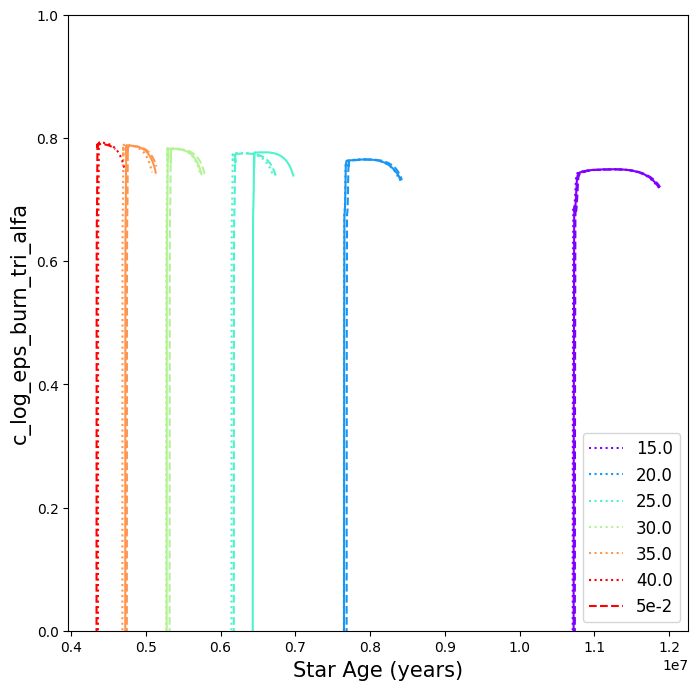

In [235]:
colors = plt.cm.rainbow(np.linspace(0,1,len(low_DWs))) #3rd num is the number of colours Set2

fig, ax = plt.subplots(figsize=(8, 8))
for i in range(len(low_DWs)):
    # identify start of MS
    # start = np.flatnonzero(np.asarray(hist.center_h1) < 0.69)[0] if (np.asarray(hist.center_h1) < 0.69).any() else 0
    
    # ax.plot(fid_DWs[i].star_age, np.log10(fid_DWs[i].c_log_eps_burn_tri_alfa) , color = colors[i], label=np.round(fid_DWs[i].star_mass[0]), ls = ':' )
    
    ax.plot(low_DWs[i].star_age, np.log10(low_DWs[i].c_log_eps_burn_tri_alfa) , color = colors[i], label=np.round(low_DWs[i].star_mass[0]), ls = ':' )
    ax.plot(mid_DWs[i].star_age, np.log10(mid_DWs[i].c_log_eps_burn_tri_alfa) , color = colors[i], label= None, ls = '-')
    ax.plot(high_DWs[i].star_age, np.log10(high_DWs[i].c_log_eps_burn_tri_alfa) , color = colors[i], label= None, ls = '--')

plt.axhline(np.log10(1e-2), color='red', linestyle='--', label='5e-2')
plt.legend(fontsize=12)
# ax.set_xlim(3.45, 4.9)
ax.set_ylim(0, 1)
plt.xlabel('Star Age (years)', fontsize=15)
plt.ylabel('c_log_eps_burn_tri_alfa', fontsize=15)
plt.show()


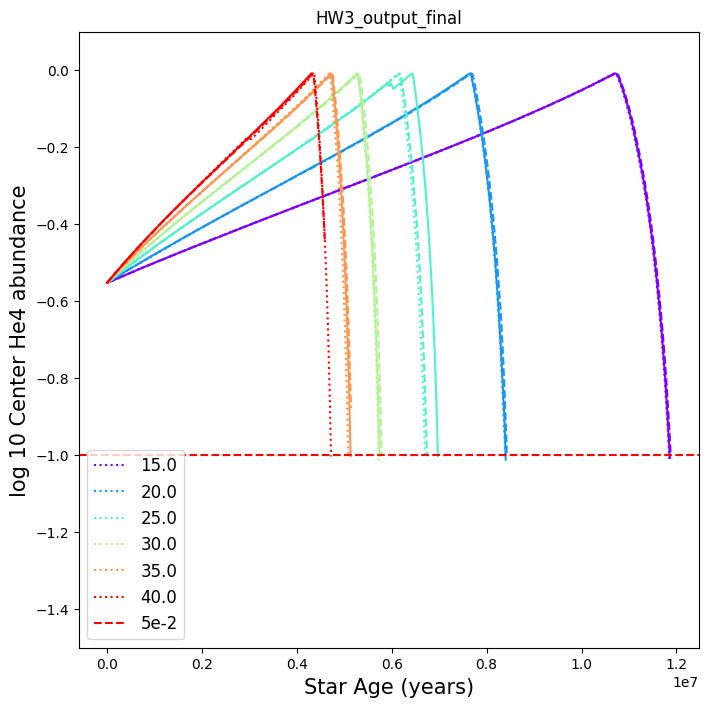

In [236]:
colors = plt.cm.rainbow(np.linspace(0,1,len(low_DWs))) #3rd num is the number of colours Set2

fig, ax = plt.subplots(figsize=(8, 8))
for i in range(len(low_DWs)):
    # identify start of MS
    # start = np.flatnonzero(np.asarray(hist.center_h1) < 0.69)[0] if (np.asarray(hist.center_h1) < 0.69).any() else 0
    
    # star_not_coreHeburng = fid_DWs[i].c_log_eps_burn_tri_alfa < 5

    # ax.plot(fid_DWs[i].star_age, np.log10(fid_DWs[i].center_he4) , color = colors[i], label=np.round(fid_DWs[i].star_mass[0]), ls = ':' )
    
    ax.plot(low_DWs[i].star_age, np.log10(low_DWs[i].center_he4) , color = colors[i], label=np.round(low_DWs[i].star_mass[0]), ls = ':' )
    ax.plot(mid_DWs[i].star_age, np.log10(mid_DWs[i].center_he4) , color = colors[i], label= None, ls = '-')
    ax.plot(high_DWs[i].star_age, np.log10(high_DWs[i].center_he4) , color = colors[i], label= None, ls = '--')


plt.axhline(np.log10(1e-1), color='red', linestyle='--', label='5e-2')
plt.legend(fontsize=12)
# ax.set_xlim(3.45, 4.9)
ax.set_ylim(-1.5, 0.1)
plt.title(var)
plt.xlabel('Star Age (years)', fontsize=15)
plt.ylabel('log 10 Center He4 abundance', fontsize=15)
plt.savefig(f"./plots/center_he_abundance_evol_{var.replace('.','_')}")
plt.show()


### PLot all the HR diagrams for these models

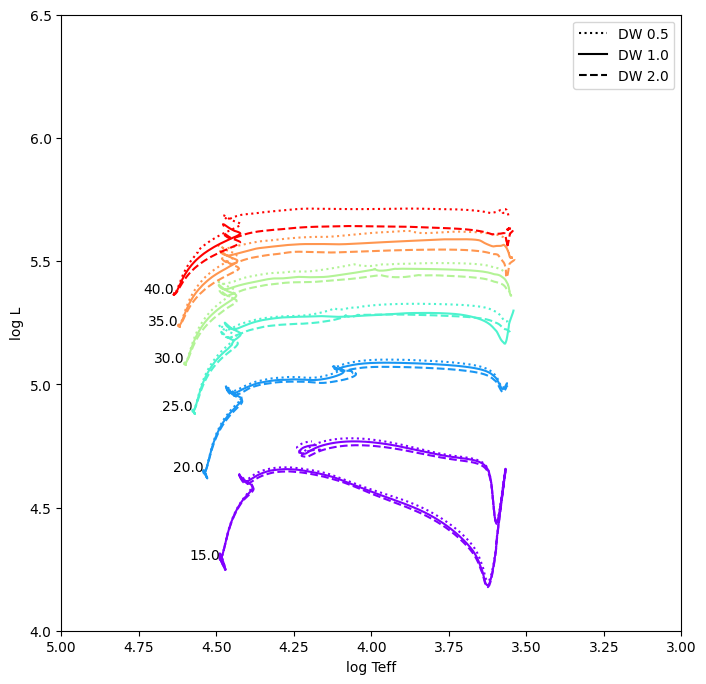

In [237]:
fig, ax = plt.subplots(figsize=(8, 8))

# Use the same colors for all masses
colors = plt.cm.rainbow(np.linspace(0,1,len(low_DWs))) #3rd num is the number of colours Set2

for i in range(len(low_DWs)):
    # star_not_coreHeburng = fid_DWs[i].c_log_eps_burn_tri_alfa < 8
    # plt.plot(fid_DWs[i].log_Teff, fid_DWs[i].log_L,color = colors[i], ls = '-')
    # ax.text(fid_DWs[i].log_Teff[0], fid_DWs[i].log_L[0],f'{np.round(fid_DWs[i].star_mass[0])}', ha = 'right')
 
    plt.plot(low_DWs[i].log_Teff, low_DWs[i].log_L,color = colors[i], ls = ':')
    plt.plot(mid_DWs[i].log_Teff, mid_DWs[i].log_L,color = colors[i], ls = '-')
    plt.plot(high_DWs[i].log_Teff, high_DWs[i].log_L,color = colors[i], ls = '--')

    ax.text(mid_DWs[i].log_Teff[0], mid_DWs[i].log_L[0], f'{np.round(mid_DWs[i].star_mass[0])}', ha = 'right')


plt.plot(-1,-1, c = 'k', label = 'DW 0.5',ls = ':')
plt.plot(-1,-1, c = 'k', label = 'DW 1.0',)
plt.plot(-1,-1, c = 'k', label = 'DW 2.0', ls = '--')

plt.legend()
ax.set_xlabel('log Teff')
ax.set_ylabel('log L')
ax.set_xlim(3, 5)
ax.invert_xaxis()
ax.set_ylim(4,6.5)

plt.show()

/var/folders/5d/vcxrsh5975l7d5n8t7vvc5pr0000gn/T/ipykernel_98131/4054448287.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


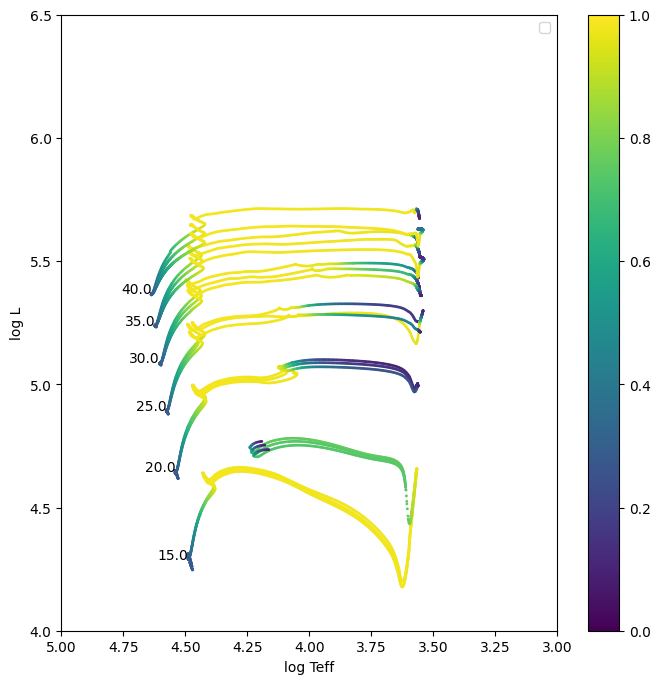

In [238]:
fig, ax = plt.subplots(figsize=(8, 8))

for i in range(len(low_DWs)):
    plt.scatter(low_DWs[i].log_Teff, low_DWs[i].log_L,c=low_DWs[i].center_he4,vmin = 0, vmax = 1., s = 1)
    plt.scatter(mid_DWs[i].log_Teff, mid_DWs[i].log_L,c=mid_DWs[i].center_he4, vmin = 0, vmax = 1., s = 1)
    plt.scatter(high_DWs[i].log_Teff, high_DWs[i].log_L,c=high_DWs[i].center_he4, vmin = 0, vmax = 1., s = 1)
    ax.text(mid_DWs[i].log_Teff[0], mid_DWs[i].log_L[0], 
    f'{np.round(mid_DWs[i].star_mass[0])}', ha = 'right')

plt.colorbar()
plt.legend()
ax.set_xlabel('log Teff')
ax.set_ylabel('log L')
ax.set_xlim(3, 5)
ax.invert_xaxis()
ax.set_ylim(4,6.5)

plt.show()

In [334]:
def plot_HR_with_radius_contours(list_of_hist_data, label_list = ['No overshoot', 'Overshoot 0.25', 'Overshoot 0.5'],
                                 save_path='plots/HR_diagram_overshoot.png',
                                 xlim=(4.5, 3.5), ylim=(3, 4.5)):
    """Plot an HR diagram with constant radius contours and MESA track overlays.
    
    Parameters:
       list_of_hist_data =  [f0_hist_data, f025_hist_data, f05_hist_data] : MesaData]
       save_path : str Where to save the output plot.
       xlim :x-axis (log Teff) limits. Default: (4.5, 3.5) for HR diagram.
       ylim : y-axis (log L) limits. Default: (3, 4.5)
    """
    
    def Radius(Teff, L):
        Teff = Teff * u.K
        L = (L * u.Lsun).to(u.W)
        R = (L / (4 * np.pi * const.sigma_sb * Teff**4))**0.5
        return R.to(u.Rsun).value

    fig, ax = plt.subplots(figsize=(9, 8))

    # --- Radius contour grid ---
    Teffs = np.linspace(1.5, 8, 100)
    Ls = np.linspace(2.0, 6.0, 100)
    Teffs_grid, Ls_grid = np.meshgrid(Teffs, Ls)
    Radius_grid = Radius(10**Teffs_grid, 10**Ls_grid)

    CS = ax.contour(Teffs_grid, Ls_grid, Radius_grid,
                    levels=[1, 10, 100, 1e3, 1e4],
                    colors='#969696', linestyles='dashed')
    ax.clabel(CS, inline=1, inline_spacing=-5, fontsize=15,
              manual=[(4.5, 3.2), (3.9, 3.2), (3.5, 3.2), (2.5, 3.2), (1.5, 3.1)])

    # --- MESA tracks ---
    for histdata, label, color in zip(
        list_of_hist_data,
        label_list,
        ['royalblue', 'green', 'crimson']
    ):
        ax.plot(histdata.log_Teff, histdata.log_L, label=label, color=color)

    # --- Axis setup ---
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_xlabel(r'$\log T_{\mathrm{eff}}$', fontsize=25)
    ax.set_ylabel(r'$\log L/L_{\odot}$', fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=20)

    ax.legend(fontsize=15)

    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()



### Helium abundance versus stellar age

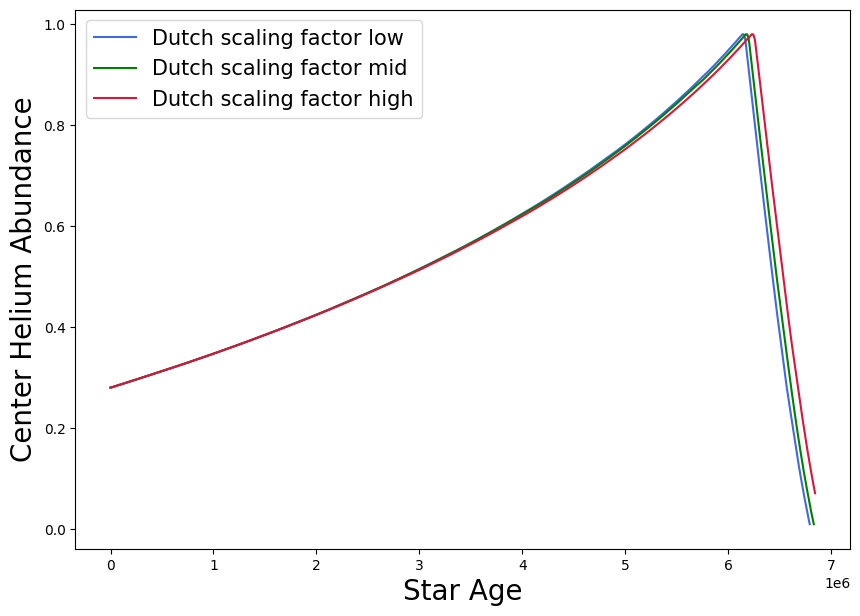

In [165]:
fig, ax = plt.subplots(figsize = (10,7))

mass_index = 2
##########
# Select the data to plot
for histdata, label, colors in zip([low_DWs[mass_index], mid_DWs[mass_index], high_DWs[mass_index]],
                                 ['Dutch scaling factor low', 'Dutch scaling factor mid', 'Dutch scaling factor high'],
                                 ['royalblue', 'green', 'crimson']):
    plt.plot(histdata.star_age, histdata.center_he4, label = label, color = colors)

# 'log_center_T', 'log_center_Rho',
plt.legend(fontsize = 15)
plt.xlabel("Star Age", fontsize = 20 )
plt.ylabel("Center Helium Abundance", fontsize = 20 )
plt.savefig('plots/M50_central_He.png', bbox_inches = 'tight')
plt.show()

Core properties didn't change much when changing the winds (which is an external thing!)

### Plot surface abundances

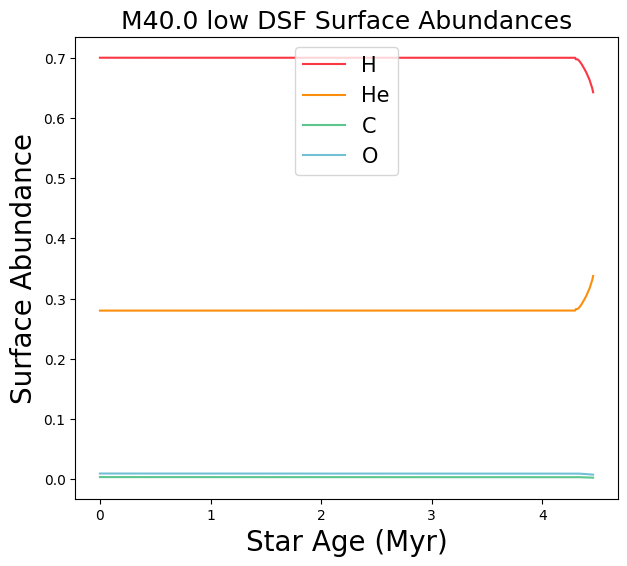

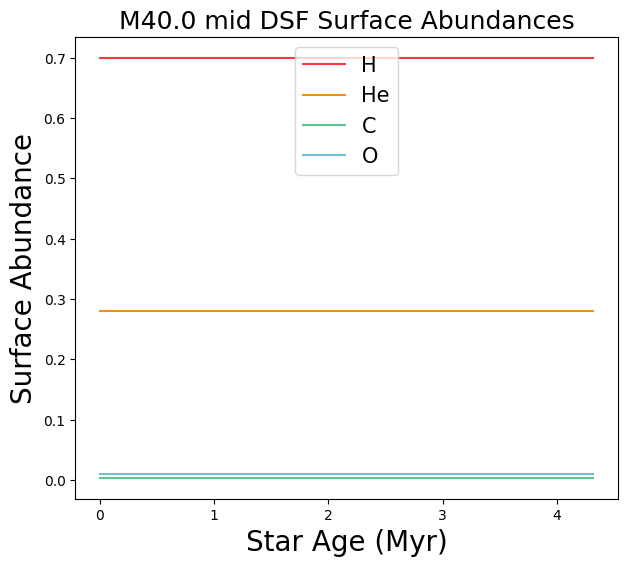

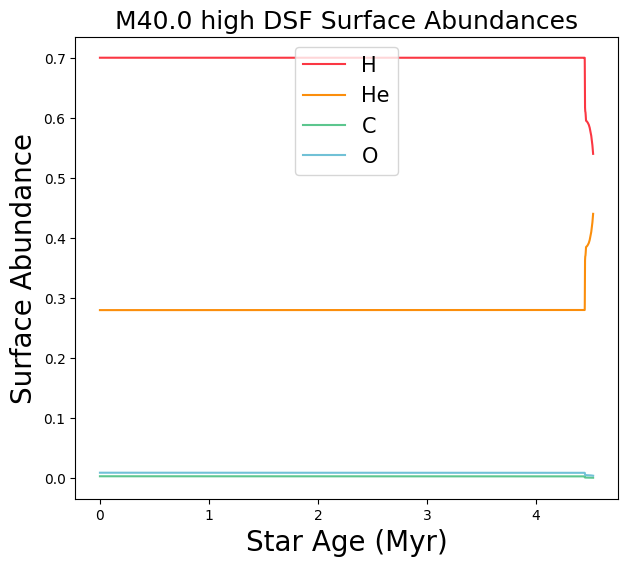

In [170]:
def plot_surface_abundances(histdata, var_name = 'DSF05'):
    fig, ax = plt.subplots(figsize = (7,6))

    ##########
    # Select the data to plot
    plt.plot(histdata.star_age*1e-6, histdata.surface_h1, label = 'H', color = '#FB3743')
    plt.plot(histdata.star_age*1e-6, histdata.surface_he4, label = 'He', color = '#FB8E0C')
    plt.plot(histdata.star_age*1e-6, histdata.surface_c12, label = 'C', color = '#5CC68E')
    plt.plot(histdata.star_age*1e-6, histdata.surface_o16, label = 'O', color = '#71C1D6')

    plt.title(f"M{np.round(histdata.star_mass[0])} {var_name} Surface Abundances", fontsize = 18)
    plt.legend(fontsize = 15)
    plt.xlabel("Star Age (Myr)", fontsize = 20 )
    plt.ylabel("Surface Abundance", fontsize = 20 )
    plt.savefig(f'plots/M_{var_name}_surface_abundances.png', bbox_inches = 'tight')
    plt.show()

mass_index = 5
plot_surface_abundances(low_DWs[mass_index], var_name='low DSF')
plot_surface_abundances(mid_DWs[mass_index], var_name='mid DSF')
plot_surface_abundances(high_DWs[mass_index], var_name='high DSF')



Surface abundances change much more when you change the winds! I.e. with stronger winds, the stars become less H rich and more He rich in their envelope. 

### Extra: abundance profile beyond core He exhaust:

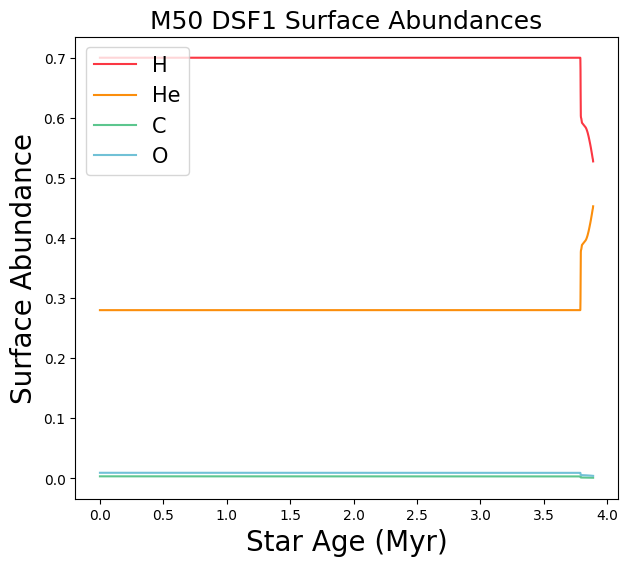

In [ ]:
# Re-read in to load the newest data
M50_DSF1_hist_data = mr.MesaData('data/M50_overshoot0_DSF1p0/LOGS/history.data')

# Plot it
plot_surface_abundances(M50_DSF1_hist_data, var_name='DSF1')


# Problem 2b Surface abundances

In [ ]:
history60_Dutch.info()

<Table length=763>
         name           dtype 
---------------------- -------
          model_number   int64
             num_zones   int64
              star_age float64
                log_dt float64
             star_mass float64
            log_xmstar float64
          log_abs_mdot float64
        mass_conv_core float64
          conv_mx1_top float64
          conv_mx1_bot float64
          conv_mx2_top float64
          conv_mx2_bot float64
               mx1_top float64
               mx1_bot float64
               mx2_top float64
               mx2_bot float64
                log_LH float64
               log_LHe float64
                log_LZ float64
              log_Lnuc float64
    log_Lnuc_sub_log_L float64
                    pp float64
                   cno float64
              tri_alfa float64
            epsnuc_M_1 float64
            epsnuc_M_2 float64
            epsnuc_M_3 float64
            epsnuc_M_4 float64
            epsnuc_M_5 float64
            epsnuc_M

In [ ]:
def plot_abundance_time(histoy_list, abund = 'surface_he4', ylab = 'He 4'):
    ###############
    ### start Figure
    fig, ax = plt.subplots(figsize=(14,10))
        
    ###############
    for i, hist in enumerate(histoy_list):
        ## Remove pre-MS
        # find index of first occurence of center_h < 70 (= primordial )
        ZAMS_i = next(ind for ind,x in enumerate(hist['center_h1']) if x < 0.69)
        hist = hist[ZAMS_i:]
        
        plt.plot(hist['star_age']/hist['star_age'][-1], hist[abund], 
                 label = np.str(np.round(hist['star_mass'][0],0))+'M$_{\odot}$')

    # Plot values
    ax.set_xlabel('fraction of star age to $^{12}$C exhaustion')
    ax.set_ylabel('surface abundance ' + ylab)
    plt.tick_params(axis='both', which='major')
    plt.xlim(0.8, 1.0)
#     plt.ylim(ylim)
    plt.yscale('log')

    plt.legend( )
    plt.savefig(save_loc +'/surfaceAbund'+abund+'.png', bbox_inches='tight')    
    plt.show()
    plt.close()


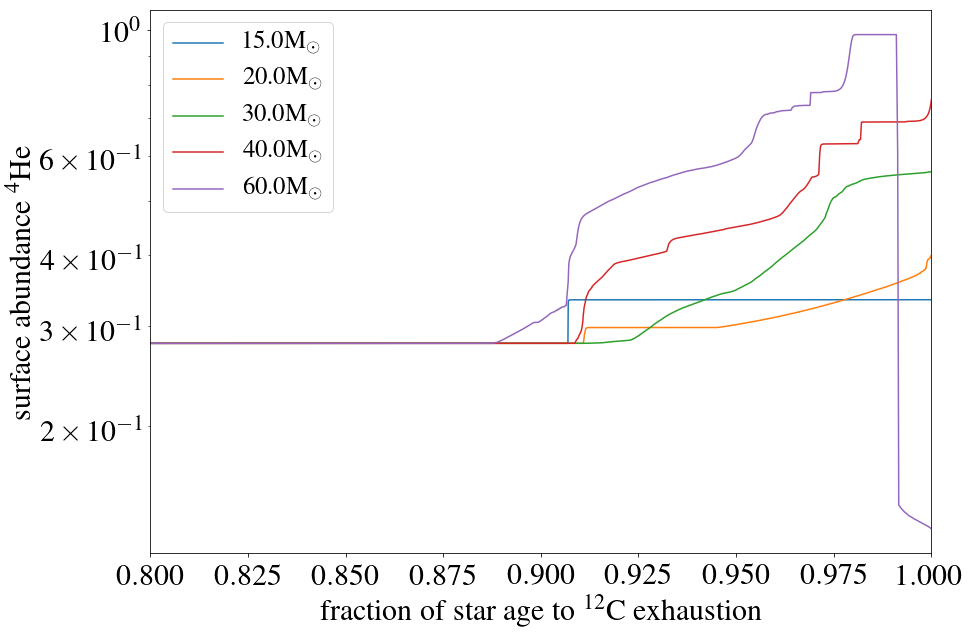

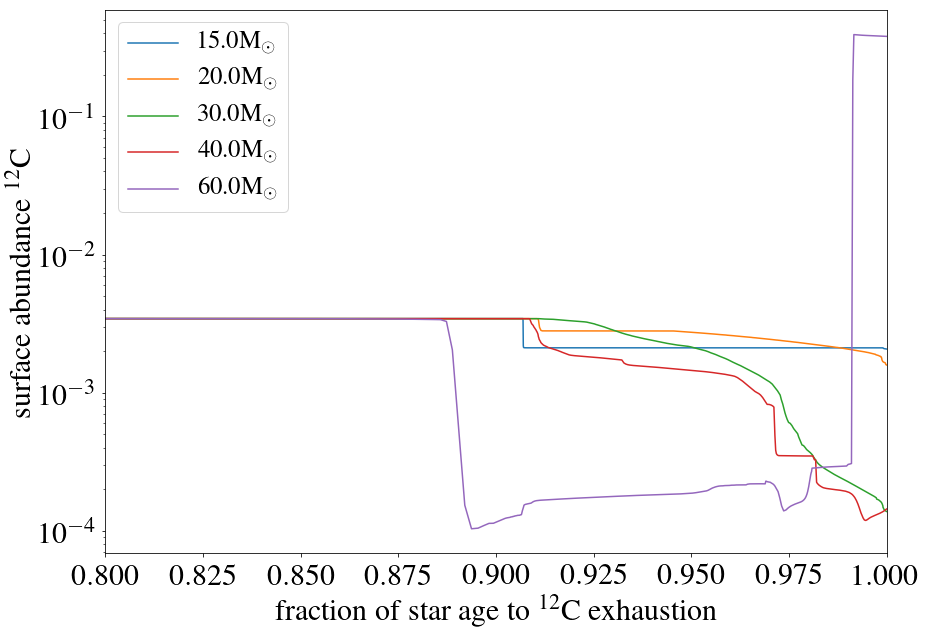

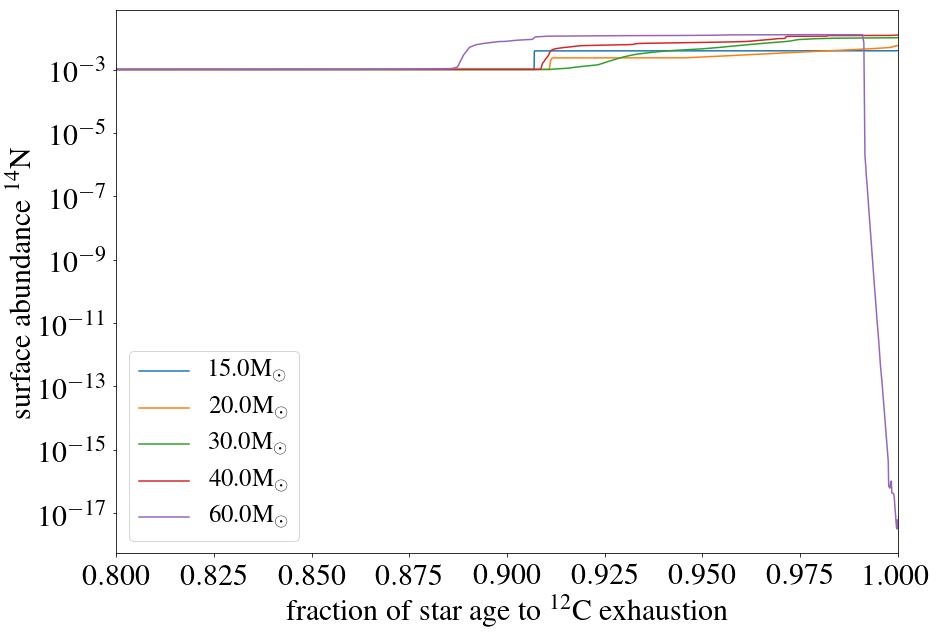

In [ ]:
plot_abundance_time(histoy_list, abund = 'surface_he4', ylab = '$^{4}$He')
plot_abundance_time(histoy_list, abund = 'surface_c12', ylab = '$^{12}$C')
plot_abundance_time(histoy_list, abund = 'surface_n14', ylab = '$^{14}$N')

In [ ]:

#Plot the HR diagram with different colour values
def HR_diagram(histoy_list, xlim = (None, None), ylim = (None,None),  VMIN =-3, VMAX = 0,
               colour_by = 'center_h1', colour_label = 'kleur',save_loc = proj_dir + '/hw4sol/plots/'):
    
    kleur = colour_by
    ###############
    ### start Figure
    fig, ax = plt.subplots(figsize=(14,10))
        
    ###############
    for i, hist in enumerate(histoy_list):
        ## Remove pre-MS
        # find index of first occurence of center_h < 70 (= primordial )
        ZAMS_i = next(ind for ind,x in enumerate(hist['center_h1']) if x < 0.69)
        hist = hist[ZAMS_i:]
        
        #Extra column
        hist['N_C'] = hist['surface_n14']/hist['surface_c12']
            
        ##plot lines
        scat = ax.scatter(hist['log_Teff'],  hist['log_L'] , label= hist_names[i],
                c = hist[kleur], vmin= VMIN, vmax = VMAX)
        ax.scatter(hist['log_Teff'][0],  hist['log_L'][0] , marker = '*') #log_Teff
        ax.text(hist['log_Teff'][0],  hist['log_L'][0] , hist_names[i], ha='right', va='top') #log_Teff

    ###############
    ### Add lines of constant radii
    log_Ts = np.arange(min(hist['log_Teff'])-2, max(hist['log_Teff'])+2, 0.1) #Array of log temperature values
    for i, logr in enumerate([-1,0,1,2,3]): #Loop over radii
        ax.plot(log_Ts, const_Rlines(log_Ts, logr), c='k', alpha = 0.3, linestyle='--')
        # Plot text
        ax.text(4.2, const_Rlines(4.2, logr), 'R = '+ str(np.round( 10**logr,2) ) +' R$_{\odot}$',
                 rotation=-60, alpha = 0.2).set_clip_on(True)
     
    #colorbar
    cb = fig.colorbar(scat, ax=ax)
    cb.set_label(colour_by.replace('_', ' '), size = 25)
    cb.set_label(colour_label, size = 25)
    cb.ax.tick_params(labelsize=20)
    
    # Show WR region
    WR_i1 = next(ind for ind,x in enumerate(history40_Dutch['surface_h1']) if x < 0.3)
    WR_i2 = next(ind for ind,x in enumerate(history60_Dutch['surface_h1']) if x < 0.3)
    T_array = np.linspace(history40_Dutch['log_Teff'][WR_i1]+0.05, 4., num =50)

    dx = history40_Dutch['log_Teff'][WR_i1] - history60_Dutch['log_Teff'][WR_i2]
    dy = history40_Dutch['log_L'][WR_i1] - history60_Dutch['log_L'][WR_i2]
    y_line = (dy/dx)*T_array + 16
    plt.plot(T_array, y_line , c = 'pink')
    plt.fill_between(x = T_array, y1 =y_line, y2 = 7,zorder = 0,
                     color='r',alpha=0.1,edgecolor='blue',hatch='/', lw = 0)
    plt.fill_between(x = np.linspace(6,history40_Dutch['log_Teff'][WR_i1]+0.05),zorder = 0,
                     y1 =y_line[0], y2 = 7,color='r',alpha=0.1,edgecolor='blue',hatch='/', lw = 0.0)
    
    
    # Plot values
    ax.set_ylabel('log$_{10}$(L/L$_{\odot}$)')
    ax.set_xlabel('log$_{10}$(T$_{eff}$/K)')
    plt.tick_params(axis='both', which='major')
    plt.xlim(xlim)
    plt.ylim(ylim)

    plt.gca().invert_xaxis()    
#     plt.legend( )
    plt.savefig(save_loc +'/HR_'+colour_by+'.png', bbox_inches='tight')    
    plt.show()
    plt.close()




In [ ]:
histoy_list = [history15_Dutch, history20_Dutch, history30_Dutch, history40_Dutch, history60_Dutch]
HistNameList   = ['15 M$_{\odot}$', '20 M$_{\odot}$', '30 M$_{\odot}$', '40 M$_{\odot}$', '60 M$_{\odot}$']
colors = plt.cm.plasma(np.linspace(0,1,4)) #3rd num is the number of colours Set2

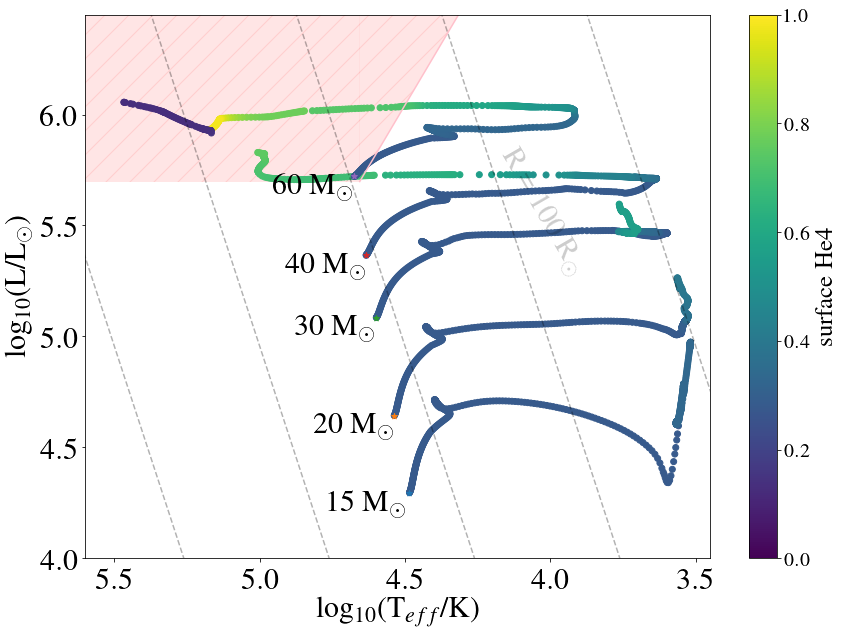

In [ ]:
# He
HR_diagram(histoy_list, xlim = (3.45,5.6), ylim= (4.,6.45), VMIN =0, VMAX = 1,
           colour_by = 'surface_he4', colour_label = 'surface He4')

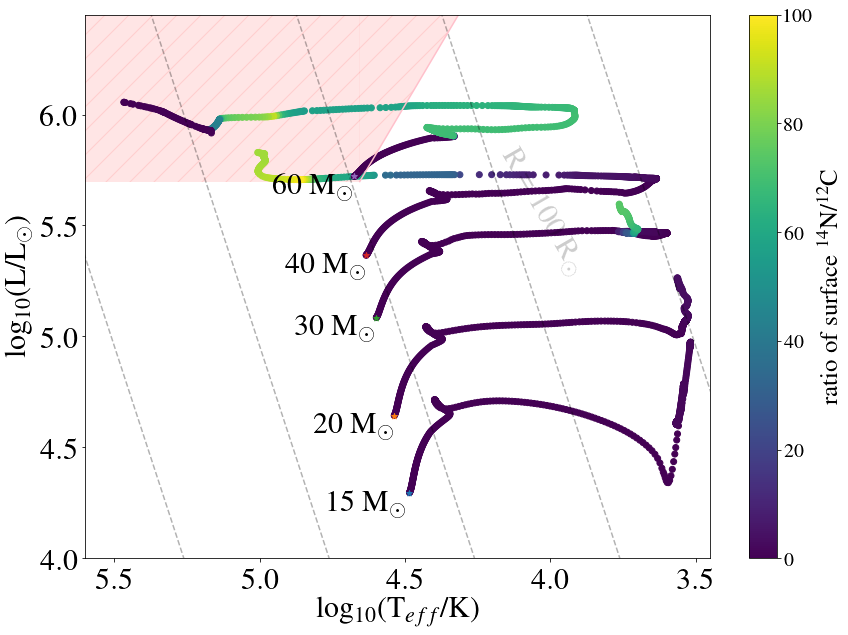

In [ ]:
# ratio Nitrogen over Carbon
HR_diagram(histoy_list, xlim = (3.45,5.6), ylim= (4.,6.45), VMIN =0, VMAX = 100,
           colour_by = 'N_C', colour_label = 'ratio of surface $^{14}$N/$^{12}$C')

# surface_h1 < 0.3


***
# 3 Radius evolution of massive stars

In [171]:
mass_index = 7
history50 = mid_DWs[mass_index]
print(np.round(history50.star_mass[0]))

# history50 = mr.MesaData('./data/session3_work/LOGS/history.data')
# history50.bulk_names


50.0


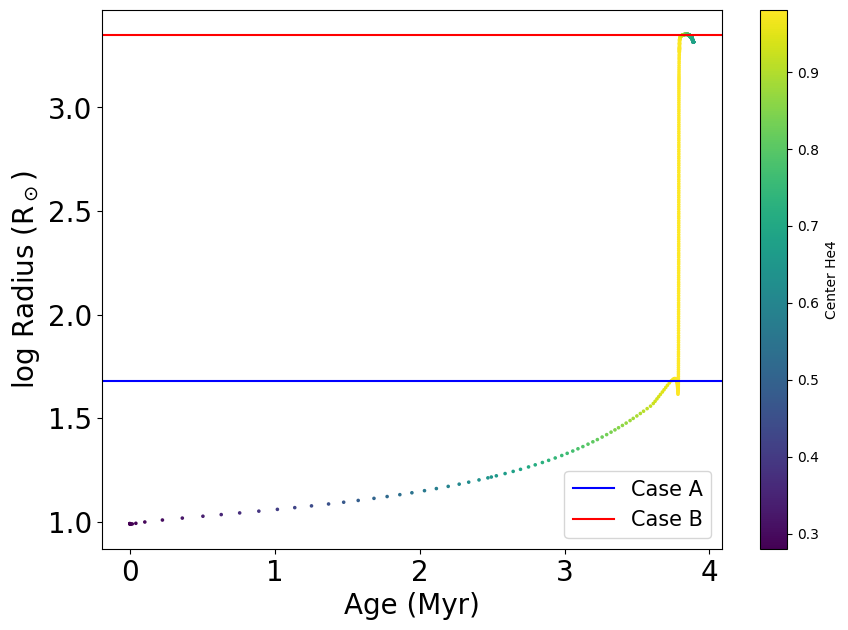

In [172]:
fig, ax = plt.subplots(figsize = (10,7))

plt.scatter(history50.star_age *1e-6, history50.log_R,
            c = history50.center_he4, s = 2.5)

plt.colorbar(label = 'Center He4')
    
plt.axhline(1.68, label = 'Case A', color = 'blue')
plt.axhline(3.35, label = 'Case B', color = 'r')

plt.xlabel('Age (Myr)', fontsize =20)
plt.ylabel('log Radius (R$_\odot$)', fontsize =20)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.legend(fontsize = 15)
plt.savefig('plots/Radius_vs_Time.png')

plt.show()  

## b) 
Assuming that the initial separations are distributed flat in log separation, we can directly map the vertical space in logR to the probability of interacting during a certain phase of expansion. 
We see that Case B mass transfer (during the HG) clearly causes the largerst radius increase and is thus the most likely kind of interaction.

In [173]:
print(f"Case A below {10**1.68} Rsun")
print(f"Case B below {10**3.35} Rsun")
print(f"Case C below {10**1.68} Rsun ")


Case A below 47.86300923226383 Rsun
Case B below 2238.72113856834 Rsun
Case C below 47.86300923226383 Rsun 


## c) 
Case A is for any radius up to about 50Rsun, Case B between 50 and about 2200 Rsun and Case C any expansion beyond 2200 Rsun

(4.7, 3.5)

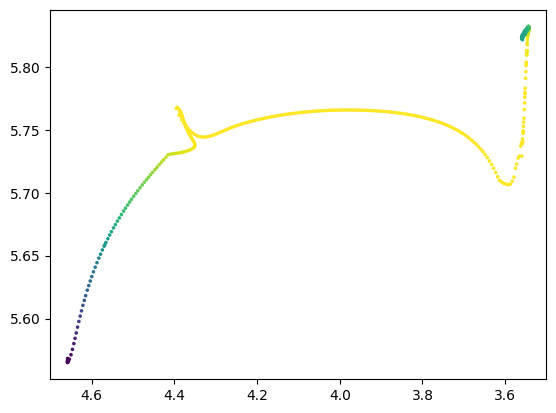

In [174]:
plt.scatter(history50.log_Teff, history50.log_L,
            c = history50.center_he4, s = 2.5)
plt.xlim(4.7, 3.5)
